# Image Captioning - Data Exploration

This notebook explores the Flickr8k dataset for the image captioning task. We will:

1. Download and prepare the dataset
2. Explore the images and captions
3. Analyze the distribution of caption lengths
4. Examine the vocabulary
5. Visualize some sample images with their captions

In [ ]:
import os
import sys
import random
# random.seed(42)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import textwrap
from PIL import Image
import nltk
from collections import Counter
from tqdm import tqdm
import re
import string
import seaborn as sns

# Add project root to path
sys.path.append('..')

# Import project modules
from data.download_flickr import download_flickr8k
from utils.vocabulary import Vocabulary, build_vocab_from_captions

## 1. Download and Prepare the Dataset

In [2]:
# Download and prepare the Flickr8k dataset
data_dir = '../data'
paths = download_flickr8k(data_dir)

File already exists at ../data\flickr8k\Flickr8k_Dataset.zip. Skipping download.
File already exists at ../data\flickr8k\Flickr8k_text.zip. Skipping download.


Extracting Flickr8k_text.zip: 100%|██████████| 10/10 [00:00<00:00, 24.29it/s]


Processed captions saved to ../data\flickr8k\processed\captions.csv


Organizing images: 100%|██████████| 8091/8091 [00:05<00:00, 1354.91it/s]


Images organized in ../data\flickr8k\processed\images
Created data splits: train (30000 captions), val (5000 captions), test (5000 captions)


In [3]:
# Load the captions
captions_path = os.path.join(paths['processed_path'], 'captions.csv')
captions_df = pd.read_csv(captions_path)

# Display the first few rows
captions_df.head(15)

image  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   
11  1002674143_1b742ab4b8.jpg   
12  1002674143_1b742ab4b8.jpg   
13  1002674143_1b742ab4b8.jpg   
14  1002674143_1b742ab4b8.jpg   

                                              caption  
0   A child in a pink dress is climbing up a set o...  
1               A girl going into a wooden building .  
2    A little girl climbing into a wooden playhouse .  
3   A little girl climbing the stairs to her playh...  
4   A little girl in a pink dress going into a woo...  
5          A black dog and a spotted dog are fighting  
6   A black dog and a tri-colored dog playing with...  
7   A black dog and a white dog with brown spots a...  
8   Two dogs of different breeds looking at each o...  
9     Two dogs on pavement moving toward each other .  
10  A little girl covered in paint sits in front o...  
11  A little girl is sitting in front of a large p...  
12  A small girl in the grass plays with fingerpai...  
13  There is a girl with pigtails sitting in front...  
14  Young girl with pigtails painting outside in t...

## 2. Explore the Images and Captions

In [4]:
# Count unique images and total captions
unique_images = captions_df['image'].nunique()
total_captions = len(captions_df)

print(f"Total number of images: {unique_images}")
print(f"Total number of captions: {total_captions}")
print(f"Average captions per image: {total_captions / unique_images:.2f}")

Total number of images: 8092
Total number of captions: 40460
Average captions per image: 5.00


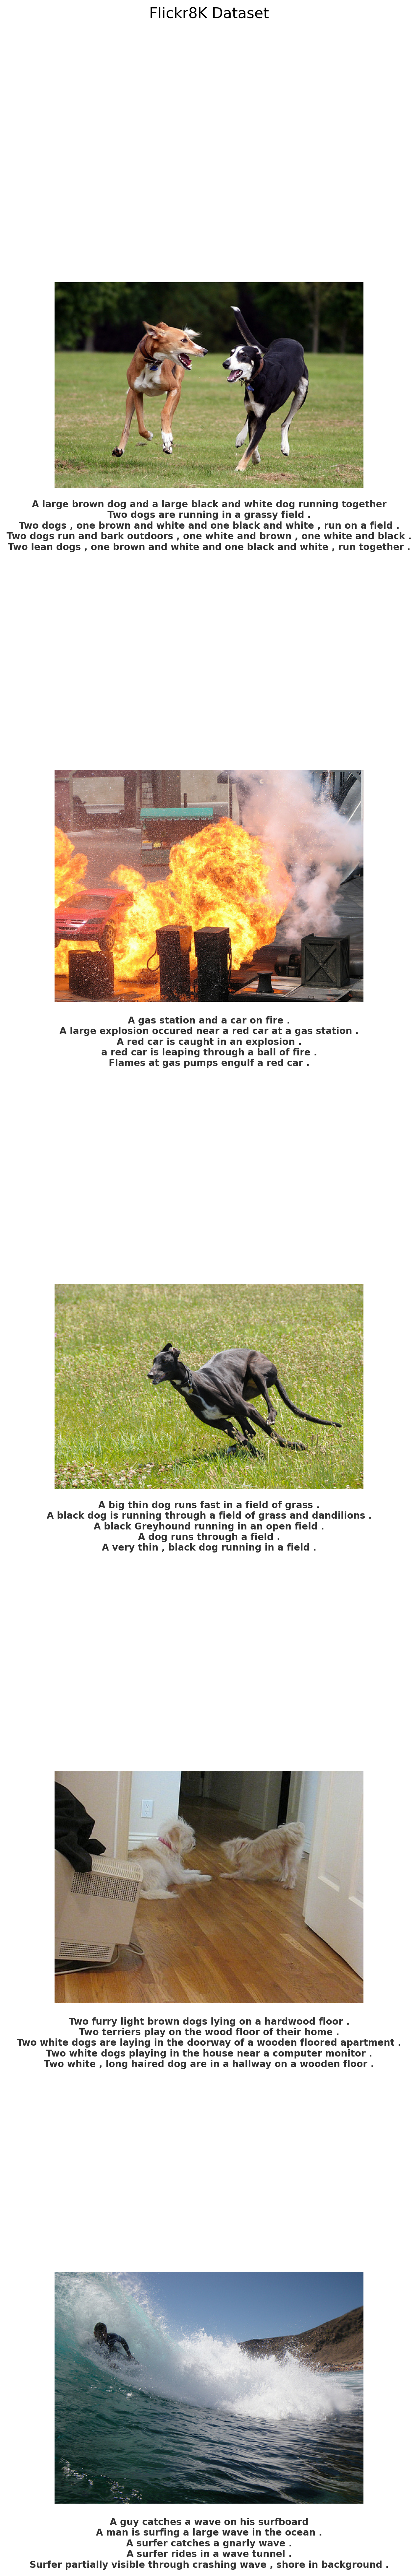

In [5]:
# Display a random sample of images with their captions
# TODO: Implement the function to display images with their captions
# This function should:
# 1. Take a DataFrame of captions, path to images directory, and number of samples
# 2. Get random image samples
# 3. Create a figure with subplots
# 4. For each image:
#    a. Load and display the image
#    b. Find all captions for that image
#    c. Add captions as a formatted title
def display_images_with_captions(captions_df: pd.DataFrame, images_dir, num_samples=5):
    # Get unique images
    # unique_image_df = captions_df.drop_duplicates(subset=['image'])
    
    # Your implementation here
    # Unique Sampling
    random_indices = list(map(lambda idx: idx * 5, random.sample(range(0, len(captions_df) // 5), num_samples)))
    random_images = captions_df.take(random_indices)['image'].to_list()
    
    df = captions_df[captions_df['image'].isin(random_images)]
    data = df.groupby('image')['caption'].agg(list).to_dict() # Structure of the result: { image_name : [list of captions(5)]}
    
    # Plotting
    fig, axes = plt.subplots(num_samples, 1, figsize=(num_samples * 1, num_samples * 8))
    
    plt.suptitle('Flickr8K Dataset', fontsize=16, y=1.02)
    
    for i, (image, captions) in enumerate(data.items()):
        img = np.array(Image.open(os.path.join(images_dir, image)))
        axes[i].imshow(img)
        axes[i].axis('off')
        caption_text = "\n".join(captions)
        axes[i].set_title(caption_text, 
                fontsize=10, 
                pad=10,  
                fontweight='semibold',
                color='#333333',
                y=-0.1,  
                verticalalignment='top')

    for ax in axes:
        ax.grid(False)  
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        
    plt.tight_layout()
    plt.show()
    
# Display some sample images with their captions
images_dir = os.path.join(paths['processed_path'], 'images')
display_images_with_captions(captions_df, images_dir)

## 3. Analyze Caption Lengths

REPORT:

| Question | Answer |
|-----------|--------|
| Should I remove "in", "on", "and", "a", etc.? | **No** |
| Why? | Because image captions must be **natural, grammatically correct sentences**. Removing small words will break that. |

✅ Keep **all words** in your tokenization (even short and common ones).

---

**limit the vocabulary size** (without removing important words) — for example, keeping the top 5000 words only and replacing rare ones with `<UNK>`.  
That's a better way to control vocabulary without hurting sentence quality!

In [ ]:
from nltk.tokenize import word_tokenize

In [7]:
# Tokenize captions
# TODO: Implement the tokenize function for caption text
# This function should:
# 1. Convert text to lowercase
# 2. Remove punctuation using regex
# 3. Split text into tokens using NLTK's word_tokenize
# 4. Return the list of tokens
def tokenize(text:str):
    text = text.lower()
    text = re.sub(r"[^a-z0-9 ]", "", text)  # Removing punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Replacing multiple spaces with one space and trim ends
    
    tokens = word_tokenize(text)
    tokens = ["startseq"] + tokens + ["endseq"]
    
    return tokens

# Calculate caption lengths
captions_df['tokens'] = captions_df['caption'].apply(tokenize)
captions_df['length'] = captions_df['tokens'].apply(len)

# Display statistics
caption_lengths = captions_df['length']
print(f"Min length: {caption_lengths.min()}")
print(f"Max length: {caption_lengths.max()}")
print(f"Mean length: {caption_lengths.mean():.2f}")
print(f"Median length: {caption_lengths.median()}")
print(f"90th percentile length: {caption_lengths.quantile(0.9)}")
print(f"95th percentile length: {caption_lengths.quantile(0.95)}")

Min length: 3
Max length: 38
Mean length: 12.79
Median length: 12.0
90th percentile length: 18.0
95th percentile length: 20.0


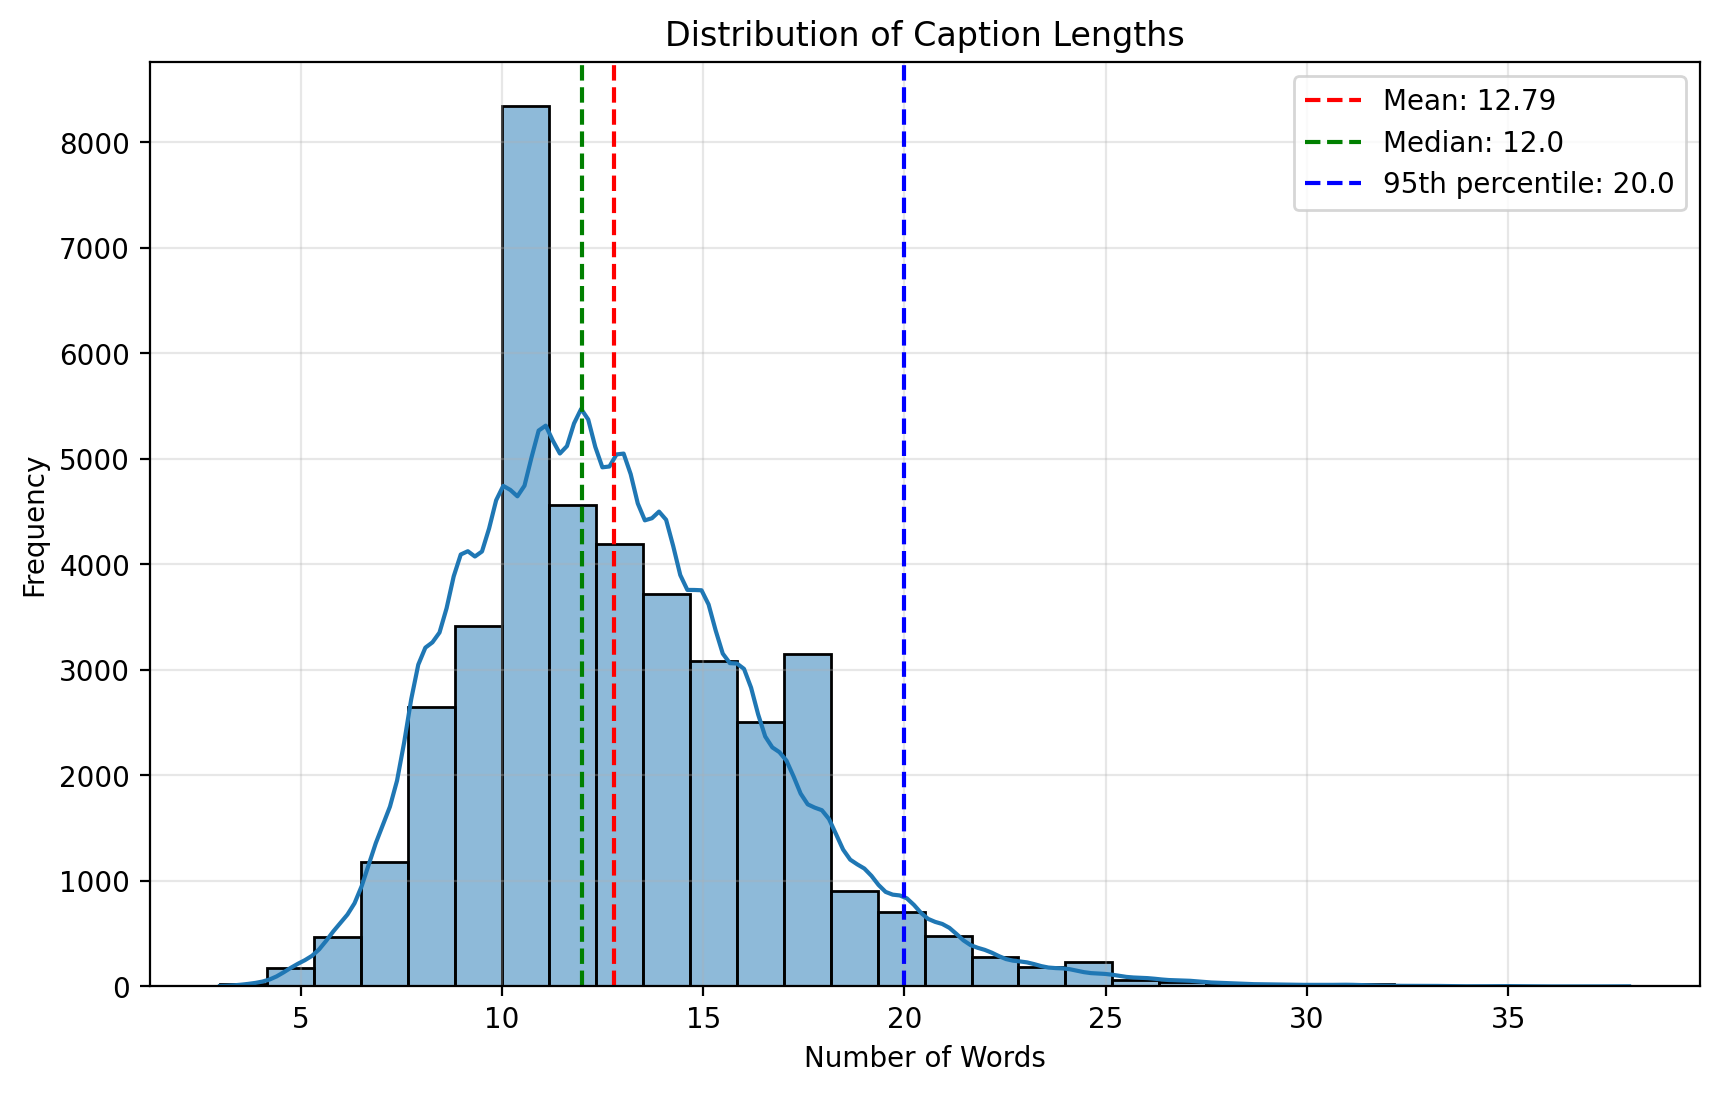

In [12]:
# Plot the distribution of caption lengths
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=30, kde=True)
plt.axvline(x=caption_lengths.mean(), color='r', linestyle='--', label=f'Mean: {caption_lengths.mean():.2f}')
plt.axvline(x=caption_lengths.median(), color='g', linestyle='--', label=f'Median: {caption_lengths.median()}')
plt.axvline(x=caption_lengths.quantile(0.95), color='b', linestyle='--', label=f'95th percentile: {caption_lengths.quantile(0.95)}')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Examine the Vocabulary

In [13]:
# Count word frequencies
all_tokens = [token for tokens in captions_df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Display statistics
print(f"Total vocabulary size: {len(word_freq)}")
print(f"Number of words appearing only once: {sum(1 for count in word_freq.values() if count == 1)}")

Total vocabulary size: 8829
Number of words appearing only once: 3608


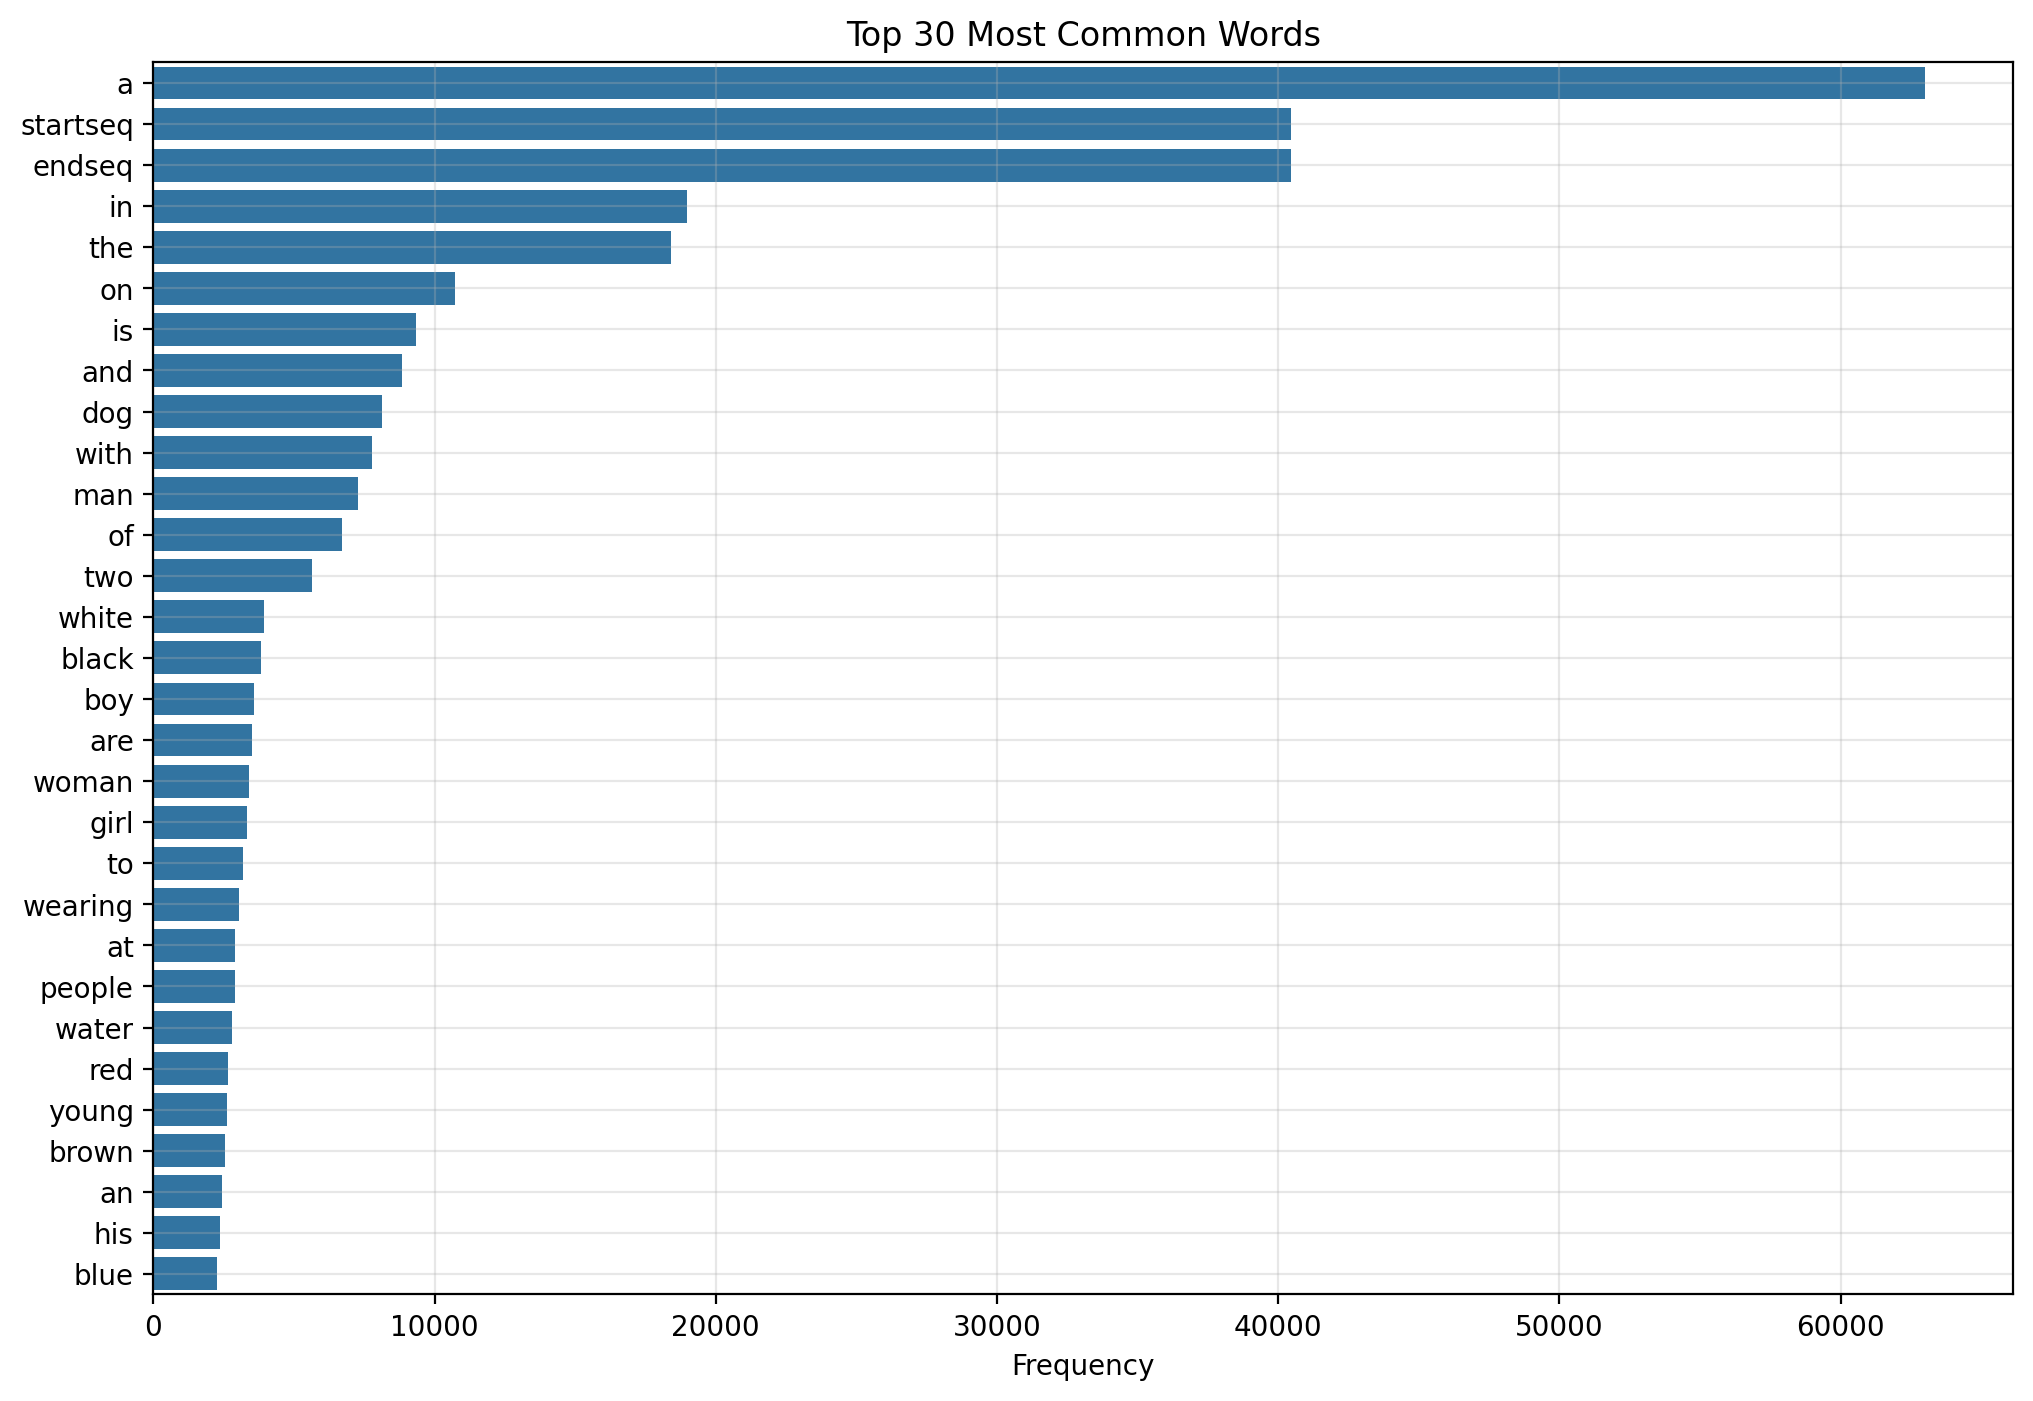

In [18]:
# Plot the most common words
top_n = 30
most_common = word_freq.most_common(top_n)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title(f'Top {top_n} Most Common Words')
plt.xlabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Calculate vocabulary coverage with different frequency thresholds
# TODO: Calculate vocabulary coverage for different word frequency thresholds
# For each threshold:
# 1. Find words that appear at least 'threshold' times
# 2. Calculate vocabulary size (number of unique words above threshold)
# 3. Calculate what percentage of all tokens are covered by this vocabulary
# 4. Store results for plotting
thresholds = [1, 2, 3, 5, 10]
coverage = []

for threshold in thresholds:
    # Your implementation here
    filtered_vocab_freq = {w:cnt for w, cnt in word_freq.items() if cnt >= threshold}
    num_filtered_tokens = sum(filtered_vocab_freq.values())
    
    vocab_size = len(filtered_vocab_freq)
    coverage_pct = (num_filtered_tokens / len(all_tokens)) * 100 
    print(f"Threshold: {threshold}, Vocabulary size: {vocab_size}, Coverage: {coverage_pct:.2f}%")
    
    coverage.append((threshold, vocab_size, coverage_pct))

Threshold: 1, Vocabulary size: 8829, Coverage: 100.00%
Threshold: 2, Vocabulary size: 5221, Coverage: 99.30%
Threshold: 3, Vocabulary size: 4095, Coverage: 98.87%
Threshold: 5, Vocabulary size: 2993, Coverage: 98.14%
Threshold: 10, Vocabulary size: 1957, Coverage: 96.83%


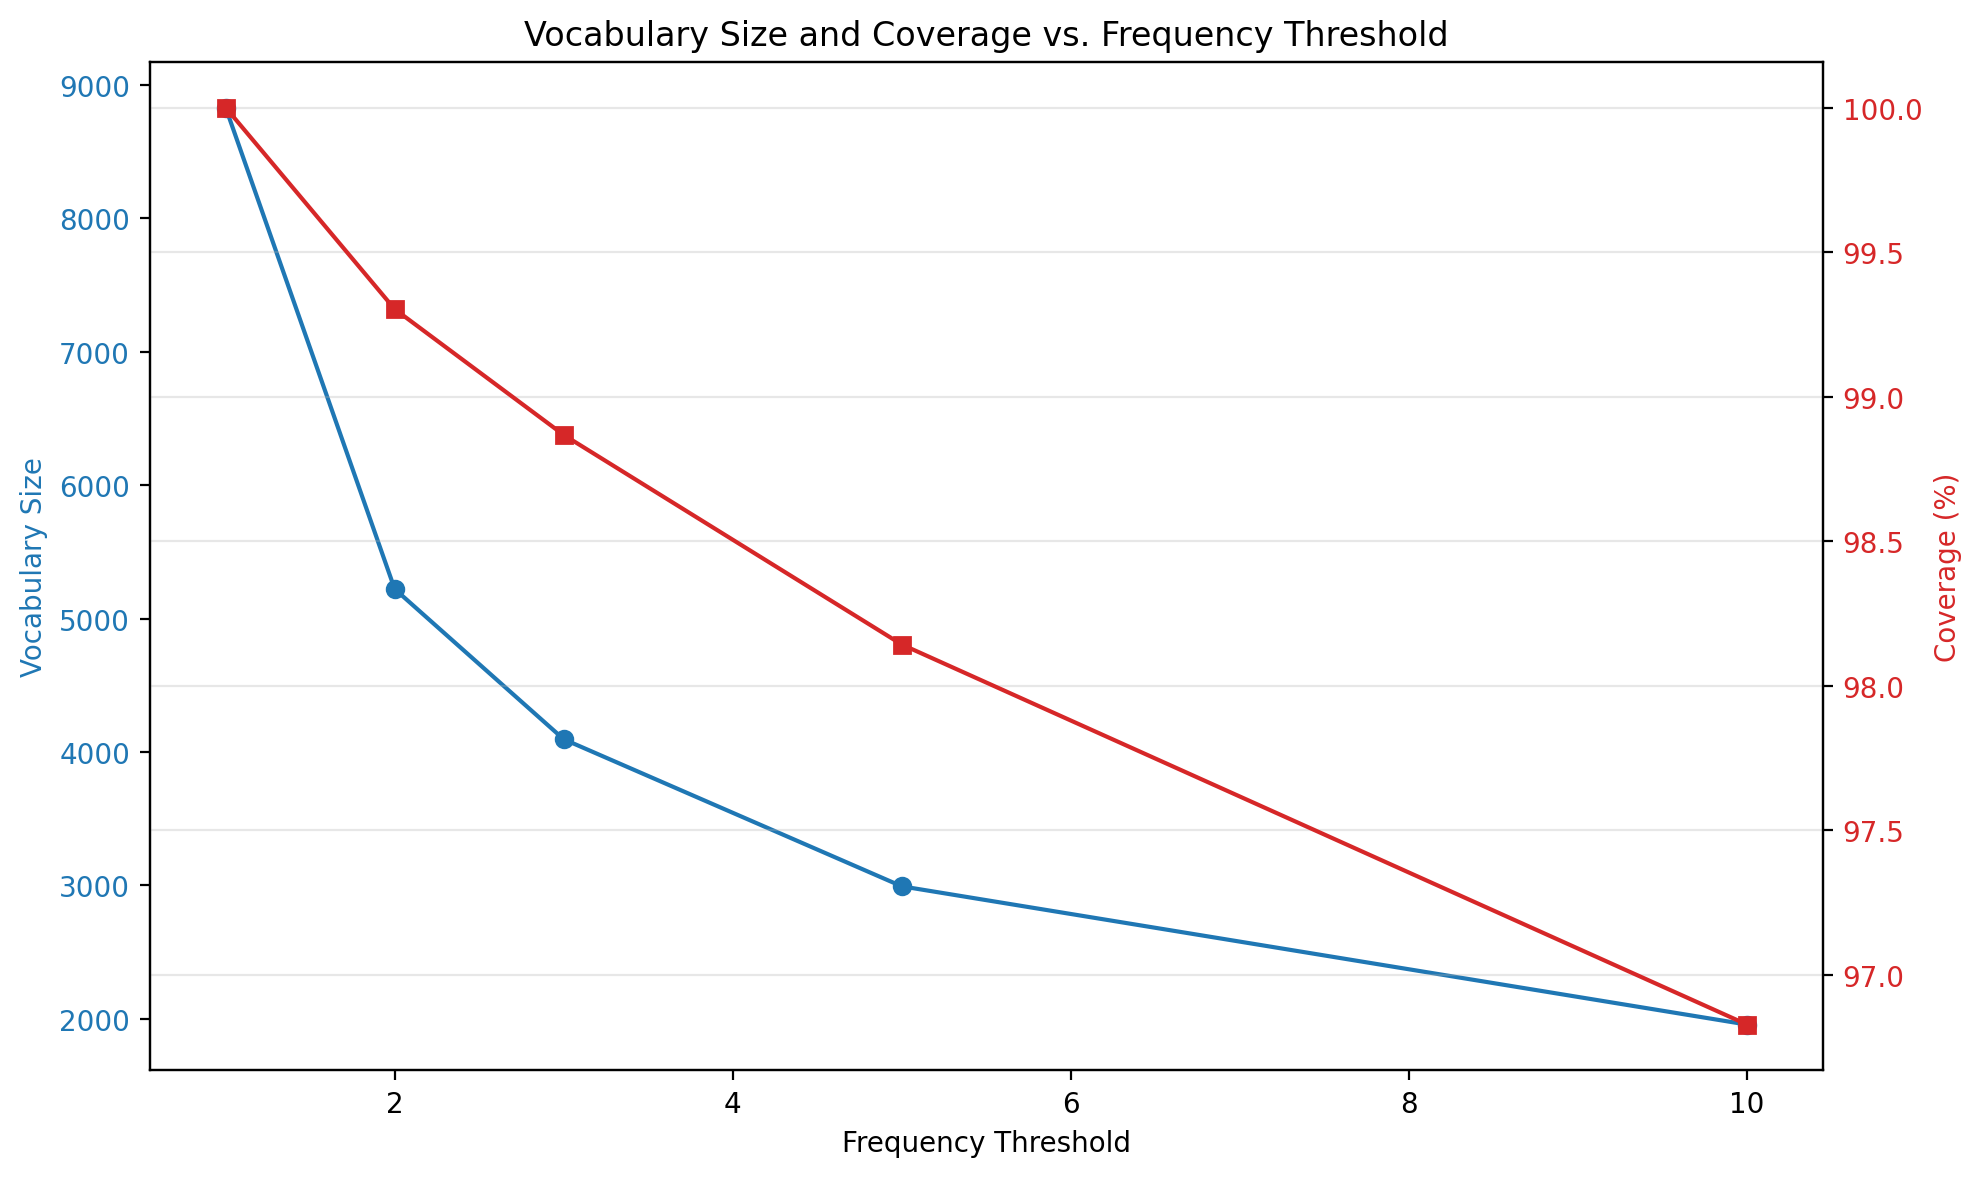

In [22]:
# Plot vocabulary coverage
thresholds, vocab_sizes, coverages = zip(*coverage)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vocabulary size
color = 'tab:blue'
ax1.set_xlabel('Frequency Threshold')
ax1.set_ylabel('Vocabulary Size', color=color)
ax1.plot(thresholds, vocab_sizes, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for coverage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (%)', color=color)
ax2.plot(thresholds, coverages, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vocabulary Size and Coverage vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Goal**:
Coverage should stay high, ideally above 95%.

Vocabulary size should be as small as possible while keeping good coverage.

**Based on your plot**:
As threshold increases:

Vocabulary size drops fast (good!),

Coverage drops slowly (still >97% even at threshold = 10).

**Quick Summary**:
Coverage is more important than tiny vocab size because your model needs to understand most common words.

Too small vocabulary → many words replaced by <UNK>, model loses fine meaning.

Too large vocabulary → model bloated, slower, harder to train.

## 5. Build and Save the Vocabulary

In [ ]:
# Build and save the vocabulary
freq_threshold = 5  # Words appearing less than 5 times are considered rare
vocab = build_vocab_from_captions(captions_path, paths['processed_path'], freq_threshold=freq_threshold)

print(f"Built vocabulary with {len(vocab)} words")

## 6. Explore Data Splits

In [ ]:
# Load data splits
train_df = pd.read_csv(os.path.join(paths['processed_path'], 'train_captions.csv'))
val_df = pd.read_csv(os.path.join(paths['processed_path'], 'val_captions.csv'))
test_df = pd.read_csv(os.path.join(paths['processed_path'], 'test_captions.csv'))

# Display statistics
print(f"Training set: {train_df['image'].nunique()} images, {len(train_df)} captions")
print(f"Validation set: {val_df['image'].nunique()} images, {len(val_df)} captions")
print(f"Test set: {test_df['image'].nunique()} images, {len(test_df)} captions")

## 7. Check Image Dimensions

In [ ]:
# Check image dimensions for a sample of images
# TODO: Implement a function to analyze image dimensions in the dataset
# This function should:
# 1. Get a sample of image files from the directory
# 2. Load each image and extract its dimensions
# 3. Return a DataFrame with width and height columns for analysis
def check_image_dimensions(images_dir, num_samples=100):
    # Your implementation here
    dim_df = ...
    return dim_df

# Check dimensions
image_dimensions = check_image_dimensions(images_dir)

# Display statistics
print("Image dimension statistics:")
print(image_dimensions.describe())

In [ ]:
# Plot image dimensions
plt.figure(figsize=(10, 8))
plt.scatter(image_dimensions['width'], image_dimensions['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## Summary

In this notebook, we have explored the Flickr8k dataset for image captioning. We have:

1. Downloaded and prepared the dataset
2. Explored the images and captions
3. Analyzed the distribution of caption lengths
4. Examined the vocabulary and its coverage
5. Built and saved the vocabulary
6. Explored the data splits
7. Checked image dimensions

This exploration gives us a good understanding of the dataset and helps us make informed decisions when designing our image captioning model.